### HOUSE SALE PRICING PREDICTION

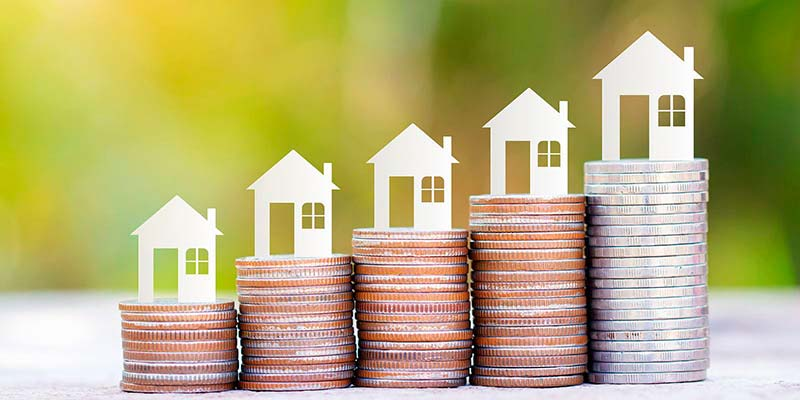

Hi folks! This is a beginners notebook that covers all the main steps necessary to complete a Machine Learning project. Here below you can see a detailed table of contents of the work:

**PREPROCESSING & EDA**

- Importing Libraries & Data
- Dealing with Duplicates and Nan
- Looking at correlations
- Data Normalization (Plots & Tests)


**MODELING**

- Baseline Models with 10-Folds CV
- Best Model (RandomGridSearch)
- Prediction
- Submission

In [ ]:
# IMPORTING LIBRARIES & MAIN PATH

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

# Defining the working directories

input_path1 = '../input/house-prices-advanced-regression-techniques/'
input_path2 = '../input/ames-housing-dataset/'

In [ ]:
# IMPORTING DATA

house_data = pd.read_csv(input_path2 + 'AmesHousing.csv')
test = pd.read_csv(input_path1 + 'test.csv')
data_w = house_data.copy()
data_w.columns = data_w.columns.str.replace(' ', '') # Replacing the white spaces in columns' names
data_w.info()

In [ ]:
data_w.head()

### EDA & VISUALIZATION

Before working with any kind of data it is important to understand them. A crucial step to this aim is the ***Exploratory data analysis (EDA)***: a combination of visualizations and statistical analysis (uni, bi, and multivariate) that helps us to better understand the data we are working with and to gain insight into their relationships. So, let's explore our target variable and how the other features influence it.

In [ ]:
# Getting the main parameters of the Normal Ditribution ()
(mu, sigma) = norm.fit(data_w['SalePrice'])

plt.figure(figsize = (12,6))
sns.distplot(data_w['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in $", fontsize = 12)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis. Looking at the plot, we can clearly see how the distribution does not seem to be normal, but highly right-skewed. The non-normality of our distribution is also supported by the Shapiro test for normality (p-value really small that allows us to reject the hypotesis of normality). Despite that, let's leave it like that for now, we'll deal with that later in the notebook. 

In [ ]:
# Skew and kurt
from scipy import stats

shap_t,shap_p = stats.shapiro(data_w['SalePrice'])

print("Skewness: %f" % abs(data_w['SalePrice']).skew())
print("Kurtosis: %f" % abs(data_w['SalePrice']).kurt())
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

The correlation matrix is the best way to see all the numerical correlation between features. Let's see which are the feature that correlate most with our target variable.

In [ ]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(30, 25))
mat = data_w.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Now that we know which features correlates most with our target variable we can investigate them more in depth.

In [ ]:
# OverallQuall - SalePrice [Pearson = 0.8]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[0])
sns.violinplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[1])
sns.boxplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[2])
plt.show()

In [ ]:
# TotRmsAbvGrd - SalePrice [Pearson = 0.50]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[0])
sns.violinplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[1])
sns.boxplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[2])
plt.show()

In [ ]:
# GrLivArea vs SalePrice [corr = 0.71]

Pearson_GrLiv = 0.71
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'GrLivArea', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('GrLivArea vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_GrLiv)], loc = 'best')
plt.show()

In [ ]:
Pearson_TBSF = 0.63
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'TotalBsmtSF', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('TotalBsmtSF vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_TBSF)], loc = 'best')
plt.show()

In [ ]:
# YearBuilt vs SalePrice

Pearson_YrBlt = 0.56
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'YearBuilt', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('YearBuilt vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_YrBlt)], loc = 'best')
plt.show()

In [ ]:
# Median of Sale Price by Year

plt.figure(figsize = (10,5))
sns.barplot(x='YrSold', y="SalePrice", data = data_w, estimator = np.median)
plt.title('Median of Sale Price by Year', fontsize = 13)
plt.xlabel('Selling Year', fontsize = 12)
plt.ylabel('Median of Price in $', fontsize = 12)
plt.show()

###  DATA PREPROCESSING

Now that we have some insights about data, we need to preprocess them for the modeling part. The main steps are:

- Looking at potential NaN
- Dealing with categorical features (e.g. Dummy coding)
- Normalization

N.B:

Usually, in a real-world project, the test data are not available until the end. For this reason, test data should contain the same type of data of the training set to preprocess them in the same way. Here, the test set is available. It contains some observations not present in the training dataset and,the use of dummy coding could raise several issues (I spent a lot of time figuring out why I was not able to make predictions on the test set). The easiest way to solve this problem (that is not applicable if test data are not available) is to concatenate Train and Test sets, preprocess, and divide them again.


In [ ]:
# Separating Target and Features

target = data_w['SalePrice']
test_id = test['Id']
test = test.drop(['Id'],axis = 1)
data_w2 = data_w.drop(['SalePrice','Order','PID'], axis = 1)


# Concatenating train & test set

train_test = pd.concat([data_w2,test], axis=0, sort=False)

In [ ]:
# Looking at NaN % within the data

nan = pd.DataFrame(train_test.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

In [ ]:
# Plotting Nan

plt.figure(figsize = (15,5))
sns.barplot(x = nan['feat'], y = nan['Perc(%)'])
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

Are we sure that all these nans are real missing values? Looking at the given description file, we can see how the majority of these nans reflect the absence of something, and for this reason, they are not nans. We can impute them (for numerical features) or substitute them with data in the file:

In [ ]:
# Converting non-numeric predictors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# Filling Categorical NaN (That we know how to fill due to the description file )

train_test['Functional'] = train_test['Functional'].fillna('Typ')
train_test['Electrical'] = train_test['Electrical'].fillna("SBrkr")
train_test['KitchenQual'] = train_test['KitchenQual'].fillna("TA")
train_test['Exterior1st'] = train_test['Exterior1st'].fillna(train_test['Exterior1st'].mode()[0])
train_test['Exterior2nd'] = train_test['Exterior2nd'].fillna(train_test['Exterior2nd'].mode()[0])
train_test['SaleType'] = train_test['SaleType'].fillna(train_test['SaleType'].mode()[0])
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test['FireplaceQu'] = train_test['FireplaceQu'].fillna("None")
train_test['Fence'] = train_test['Fence'].fillna("None")
train_test['MiscFeature'] = train_test['MiscFeature'].fillna("None")

for col in ('GarageArea', 'GarageCars'):
    train_test[col] = train_test[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_test[col] = train_test[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_test[col] = train_test[col].fillna('None')
    
    # Checking the features with NaN remained out

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

In [ ]:
# Removing the useless variables

useless = ['GarageYrBlt','YearRemodAdd'] 
train_test = train_test.drop(useless, axis = 1)

# Imputing with KnnRegressor (we can also use different Imputers)

def impute_knn(df):
    ttn = train_test.select_dtypes(include=[np.number])
    ttc = train_test.select_dtypes(exclude=[np.number])

    cols_nan = ttn.columns[ttn.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ttn.columns.difference(cols_nan).values     # columns w/n nan

    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ttn.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ttn,ttc],axis=1)

train_test = impute_knn(train_test)


objects = []
for i in train_test.columns:
    if train_test[i].dtype == object:
        objects.append(i)
train_test.update(train_test[objects].fillna('None'))

# # Checking NaN presence

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

### FEATURE ENGINEERING

Let's create some new features combining the ones that we already have. These could help us to increase the performance of the model!

In [ ]:
train_test["SqFtPerRoom"] = train_test["GrLivArea"] / (train_test["TotRmsAbvGrd"] +
                                                       train_test["FullBath"] +
                                                       train_test["HalfBath"] +
                                                       train_test["KitchenAbvGr"])

train_test['Total_Home_Quality'] = train_test['OverallQual'] + train_test['OverallCond']

train_test['Total_Bathrooms'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) +
                               train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

train_test["HighQualSF"] = train_test["1stFlrSF"] + train_test["2ndFlrSF"]

# Converting non-numeric predictors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# Creating dummy variables from categorical features

train_test_dummy = pd.get_dummies(train_test)

# Fetch all numeric features

#train_test['Id'] = train_test['Id'].apply(str)
numeric_features = train_test_dummy.dtypes[train_test_dummy.dtypes != object].index
skewed_features = train_test_dummy[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using log_transformation
    
for i in skew_index:
    train_test_dummy[i] = np.log1p(train_test_dummy[i])

Now let's try to tranform our target distribution into a normal one. To do this we use a log transformation. We will use qq-plot to see the transformation effect.  

In [ ]:
# SalePrice before transformation

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

In [ ]:
# SalePrice after transformation

target_log = np.log1p(target)

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target_log, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(target_log, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

### MODELING

In [ ]:
import shap
import xgboost as xgb
from catboost import Pool
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [ ]:
# Train-Test separation

train = train_test_dummy[0:2930]
test = train_test_dummy[2930:]
test['Id'] = test_id

# Creation of the RMSE metric:
    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_log, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [ ]:
# 10 Fold Cross validation

kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

baseline_models = ['Linear_Reg.','Bayesian_Ridge_Reg.','LGBM_Reg.','SVR',
                   'Dec_Tree_Reg.','Random_Forest_Reg.', 'XGB_Reg.',
                   'Grad_Boost_Reg.','Cat_Boost_Reg.','Stacked_Reg.']

# Linear Regression

lreg = LinearRegression()
score_lreg = cv_rmse(lreg)
cv_scores.append(score_lreg.mean())
cv_std.append(score_lreg.std())

# Bayesian Ridge Regression

brr = BayesianRidge(compute_score=True)
score_brr = cv_rmse(brr)
cv_scores.append(score_brr.mean())
cv_std.append(score_brr.std())

# Light Gradient Boost Regressor

l_gbm = LGBMRegressor(objective='regression')
score_l_gbm = cv_rmse(l_gbm)
cv_scores.append(score_l_gbm.mean())
cv_std.append(score_l_gbm.std())

# Support Vector Regression

svr = SVR()
score_svr = cv_rmse(svr)
cv_scores.append(score_svr.mean())
cv_std.append(score_svr.std())

# Decision Tree Regressor

dtr = DecisionTreeRegressor()
score_dtr = cv_rmse(dtr)
cv_scores.append(score_dtr.mean())
cv_std.append(score_dtr.std())

# Random Forest Regressor

rfr = RandomForestRegressor()
score_rfr = cv_rmse(rfr)
cv_scores.append(score_rfr.mean())
cv_std.append(score_rfr.std())

# XGB Regressor

xgb = xgb.XGBRegressor()
score_xgb = cv_rmse(xgb)
cv_scores.append(score_xgb.mean())
cv_std.append(score_xgb.std())

# Gradient Boost Regressor

gbr = GradientBoostingRegressor()
score_gbr = cv_rmse(gbr)
cv_scores.append(score_gbr.mean())
cv_std.append(score_gbr.std())

# Cat Boost Regressor

catb = CatBoostRegressor()
score_catb = cv_rmse(catb)
cv_scores.append(score_catb.mean())
cv_std.append(score_catb.std())

# Stacked Regressor

stack_gen = StackingRegressor(regressors=(CatBoostRegressor(),
                                          LinearRegression(),
                                          BayesianRidge(),
                                          GradientBoostingRegressor()),
                              meta_regressor = CatBoostRegressor(),
                              use_features_in_secondary = True)

score_stack_gen = cv_rmse(stack_gen)
cv_scores.append(score_stack_gen.mean())
cv_std.append(score_stack_gen.std())

final_cv_score = pd.DataFrame(baseline_models, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std

In [ ]:
final_cv_score

In [ ]:
plt.figure(figsize = (12,8))
sns.barplot(final_cv_score['Regressors'],final_cv_score['RMSE_mean'])
plt.xlabel('Regressors', fontsize = 12)
plt.ylabel('CV_Mean_RMSE', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Train-Test split the data

X_train,X_val,y_train,y_val = train_test_split(train,target_log,test_size = 0.1,random_state=42)

# Cat Boost Regressor

cat = CatBoostRegressor()
cat_model = cat.fit(X_train,y_train,
                     eval_set = (X_val,y_val),
                     plot=True,
                     verbose = 0)

In [ ]:
cat_pred = cat_model.predict(X_val)
cat_score = rmse(y_val, cat_pred)
cat_score

Now let's take a look at the top 20 most important variables for our model. This could give us further insight into the functioning of the algorithm and how and which data it uses most to arrive at the final prediction.

In [ ]:
# Features' importance of our model

feat_imp = cat_model.get_feature_importance(prettified=True)
feat_imp

In [ ]:
# Plotting top 20 features' importance

plt.figure(figsize = (12,8))
sns.barplot(feat_imp['Importances'][:20],feat_imp['Feature Id'][:20], orient = 'h')
plt.show()

In [ ]:
# Feature importance Interactive Plot 

train_pool = Pool(X_train)
val_pool = Pool(X_val)

explainer = shap.TreeExplainer(cat_model) # insert your model
shap_values = explainer.shap_values(train_pool) # insert your train Pool object

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])

# The plot represents just a slice of the Training data (200 observations)

In [ ]:
shap.summary_plot(shap_values, X_train)

The above diagram represents each observation (x-axis) for the feature presented (y-axis). The x location of each dot on the x-axis reflects the impact of that feature on the model's predictions, while the color of the dot represents the value of that feature for that exact observation. Dots that pile up on the line show density. Here we can see how features such as 'BsmtFinType1_GLQ' or 'BsmtQual_Ex', differently from 'GrLivArea' and 'OverallQual', do not contribute significantly in producing the final predictions.



 N.B: Catboost comes with a great method: ***get_feature_importance***. This method can be used to find important interactions among features. This is a huge advantage because it can give us insights about possible new features to create that can improve the performance.  

In [ ]:
# Features' Interactions

train_data = Pool(X_train)

interaction = cat_model.get_feature_importance(train_data, type="Interaction")
column_names = X_train.columns.values 
interaction = pd.DataFrame(interaction, columns=["feature1", "feature2", "importance"])
interaction.feature1 = interaction.feature1.apply(lambda l: column_names[int(l)])
interaction.feature2 = interaction.feature2.apply(lambda l: column_names[int(l)])
interaction.head(20)

Which are the deafult parameters used by CaboostRegressor? This is our real baseline, now we need to optimize the hyperparameters trying to tune the model to obtain a better performance.

In [ ]:
# Catboost default paramters

cat_model.get_all_params()

### Hyperparameter Optimization

In [ ]:
# Preforming a Random Grid Search to find the best combination of parameters

grid = {'iterations': [1000,6000],
        'learning_rate': [0.05, 0.005, 0.0005],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 9]}

final_model = CatBoostRegressor()
randomized_search_result = final_model.randomized_search(grid,
                                                   X = X_train,
                                                   y= y_train,
                                                   verbose = False,
                                                   plot=True)
                                                   

In [ ]:
# Final Cat-Boost Regressor

params = {'iterations': 6000,
          'learning_rate': 0.005,
          'depth': 4,
          'l2_leaf_reg': 1,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': 42}
         
cat_f = CatBoostRegressor(**params)
cat_model_f = cat_f.fit(X_train,y_train,
                     eval_set = (X_val,y_val),
                     plot=True,
                     verbose = False)

catf_pred = cat_model_f.predict(X_val)
catf_score = rmse(y_val, catf_pred)

In [ ]:
catf_score

### SUBMISSION

In [ ]:
# Test CSV Submission

test_pred = cat_f.predict(test)
submission = pd.DataFrame(test_id, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred 
submission.head()

In [ ]:
# Saving the results in a csv file

submission.to_csv("result.csv", index = False, header = True)